In [1]:
#importing all the basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import datetime

In [2]:
#importing the data
csv_file = 'taxi.csv'
df = pd.read_csv(csv_file, sep=',', index_col=0)
df.describe()

,VendorID,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,28454.000000,28454.00000,28454.000000,28454.000000,28454.000000,28454.000000,28454.000000,28454.000000,28454.000000,28454.000000,28454.000000,28454.000000,28454.000000,28454.000000,28454.000000,28454.000000
mean,1.530857,1.64360,13.374979,-72.754727,40.079531,1.037359,-72.837611,40.126010,1.330358,17.879753,0.326986,0.498002,1.762671,0.285483,0.299726,21.052621
std,0.499056,1.30007,1772.032130,9.418807,5.188718,0.638046,9.096966,5.011552,0.484630,917.746560,0.450626,0.034350,2.348040,1.369447,0.011794,917.887853
min,1.000000,0.00000,0.000000,-74.177383,0.000000,1.000000,-74.344337,0.000000,1.000000,-52.000000,-1.000000,-0.500000,0.000000,0.000000,-0.300000,-52.800000
25%,1.000000,1.00000,1.000000,-73.991722,40.736568,1.000000,-73.991234,40.734502,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,0.300000,8.300000
50%,2.000000,1.00000,1.680000,-73.981335,40.753445,1.000000,-73.979668,40.753859,1.000000,9.000000,0.000000,0.500000,1.350000,0.000000,0.300000,11.750000
75%,2.000000,2.00000,3.060000,-73.966524,40.767941,1.000000,-73.962257,40.769294,2.000000,14.000000,0.500000,0.500000,2.350000,0.000000,0.300000,17.160000
max,2.000000,6.00000,298914.200000,0.000000,40.955898,99.000000,0.000000,41.143021,4.000000,154810.430000,20.550000,1.160000,54.000000,61.050000,0.300000,154832.140000


In [3]:
#no NAs
df.isna().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
pickup_longitude         0
pickup_latitude          0
RatecodeID               0
store_and_fwd_flag       0
dropoff_longitude        0
dropoff_latitude         0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
GoodTip                  0
Extra                    0
Cash                     0
dtype: int64

In [4]:
#let us see sets of values for each column to identify abnormalities
for column in df.columns:
    print(column, df[column].unique(), '\n')

VendorID [1 2] 

tpep_pickup_datetime ['2016-02-19 20:50:54' '2016-02-19 20:51:17' '2016-02-19 20:54:38' ...
 '2016-02-29 00:00:50' '2016-02-29 00:22:13' '2016-02-29 10:11:21'] 

tpep_dropoff_datetime ['2016-02-19 21:09:54' '2016-02-19 20:57:07' '2016-02-19 21:07:51' ...
 '2016-02-29 00:11:16' '2016-02-29 00:27:17' '2016-02-29 10:12:29'] 

passenger_count [1 2 5 4 6 3 0] 

trip_distance [ 3.2   0.9   2.8  ...  6.18 56.6  15.51] 

pickup_longitude [-73.97509766 -73.97607422 -73.96616364 ... -73.93688202 -73.94875336
 -73.78341675] 

pickup_latitude [40.76479721 40.75268173 40.7648201  ... 40.6435318  40.64865112
 40.75868988] 

RatecodeID [ 1  2  5  4  3  6 99] 

store_and_fwd_flag ['N' 'Y'] 

dropoff_longitude [-74.00676727 -73.98387909 -73.96067047 ... -73.92103577 -74.00244141
 -73.93723297] 

dropoff_latitude [40.74045944 40.74348831 40.7974472  ... 40.77493668 40.72312164
 40.7120018 ] 

payment_type [2 1 3 4] 

fare_amount [ 1.4500000e+01  5.5000000e+00  1.2000000e+01  1.1000000e+

In [5]:
#getting rid of strange observations
df.drop(index=df[df['RatecodeID']==99].index, inplace=True) #one single row without payment
df.drop(index=df[df['passenger_count']==0].index, inplace=True)#one single row with just wrong values - distance is not zero, , the fair was negotiated, the money was paid, but no passengers. If there were more rows like that, we would assume it is a pre-ordered taxi, but there is the only one. So we delete it.
df.drop(index=df[df['trip_distance']>100].index, inplace=True)
df.drop(index=df[df['pickup_longitude']==0].index, inplace=True) #geographical coordinates are not really numerical, so replacing with mode, median or mean is not reasonable and keeping zeros is wrong. So we just sacrifice these rows
df.drop(index=df[df['dropoff_longitude']==0].index, inplace=True)
df.drop(index=df[df['dropoff_latitude']==0].index, inplace=True)
df.drop(index=df[df['pickup_latitude']==0].index, inplace=True)
df=df.reset_index().drop(columns='index', axis=1)    
df['fare_amount']=df['fare_amount'].abs()
df['extra']=df['extra'].abs()
df.loc[df[df.trip_distance<=0.001].index, 'mta_tax'] = 0
df['mta_tax']=df['mta_tax'].abs()
df['improvement_surcharge']=df['improvement_surcharge'].abs()
df.loc[df[df.trip_distance<=0.001].index,'improvement_surcharge']=0.0
df.loc[df[df.trip_distance>0.001].index,'improvement_surcharge']=0.3
df['total_amount']=df['total_amount'].abs()

In [6]:
def to_bool(string):
    if string=='N':
        flag=False
    if string=='Y':  
        flag=True
    return flag

df['store_and_fwd_flag']=df['store_and_fwd_flag'].apply(to_bool)

In [7]:
#dealing with the datetime
df.insert(column='pickuptime', value = pd.to_datetime(df['tpep_pickup_datetime'], format = '%Y-%m-%d %H:%M:%S'), loc=2)
df.insert(column='pickupweekday', value = df['pickuptime'].dt.dayofweek,  loc=3)
df.insert(column='pickupmonth', value = df['pickuptime'].dt.month, loc=4)
df.insert(column='pickuphour', value = df['pickuptime'].dt.hour, loc=5)
df.insert(column='pickupminute', value = df['pickuptime'].dt.minute, loc=6)
df.insert(column='pickupsecond', value = df['pickuptime'].dt.second, loc=7)
df.insert(column='dropofftime', value = pd.to_datetime(df['tpep_dropoff_datetime'], format = '%Y-%m-%d %H:%M:%S'),  loc=9)
df.insert(column='dropoffweekday', value = df['dropofftime'].dt.dayofweek,  loc=10)
df.insert(column='dropoffmonth', value = df['dropofftime'].dt.month, loc=11)
df.insert(column='dropoffhour', value = df['dropofftime'].dt.hour, loc=12)
df.insert(column='dropoffminute', value = df['dropofftime'].dt.minute, loc=13)
df.insert(column='dropoffsecond', value = df['dropofftime'].dt.second, loc=14)

In [8]:
#getting dummies for the categorical variables
df = pd.concat([df[['VendorID', 'RatecodeID', 'payment_type']], pd.get_dummies(data=df, drop_first=True, columns=['VendorID', 'RatecodeID', 'payment_type'])], axis=1)

In [9]:
#let us order the columns in more convenient way
cols = ['VendorID', 'RatecodeID', 'payment_type', 'tpep_pickup_datetime', 'pickuptime', 'tpep_dropoff_datetime', 'dropofftime', 'pickupmonth', 'dropoffmonth',
'dropoff_longitude', 'dropoff_latitude', 'pickup_longitude', 'pickup_latitude',
'pickupweekday', 'pickuphour', 'pickupminute', 'pickupsecond',
'dropoffweekday', 'dropoffhour', 'dropoffminute', 'dropoffsecond',
'passenger_count',
'RatecodeID_2', 'RatecodeID_3', 'RatecodeID_4', 'RatecodeID_5', 'RatecodeID_6', 'trip_distance', 'store_and_fwd_flag',
'fare_amount','extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
'GoodTip', 'Extra', 
'VendorID_2', 'payment_type_2', 'payment_type_3', 'payment_type_4',
'Cash']
df = df[cols]

In [ ]:
sns.pairplot(df)
plt.show()
#the plots are of different shape, but are monotonous unless pointless due to values being discrete 

dropoff_longitude        0.038460
dropoff_latitude         0.042964
pickup_longitude         0.031054
pickup_latitude          0.036826
pickupweekday            0.027349
pickuphour              -0.023039
pickupminute             0.003934
pickupsecond             0.012377
dropoffweekday           0.026302
dropoffhour             -0.018926
dropoffminute            0.007861
dropoffsecond           -0.000150
passenger_count          0.013819
RatecodeID_2            -0.013986
RatecodeID_3            -0.008760
RatecodeID_4            -0.013600
RatecodeID_5            -0.022823
RatecodeID_6            -0.004100
trip_distance           -0.058498
store_and_fwd_flag       0.000627
fare_amount             -0.068576
extra                   -0.028431
mta_tax                 -0.012289
tip_amount              -0.515912
tolls_amount            -0.041434
improvement_surcharge   -0.029273
total_amount            -0.154031
GoodTip                 -0.541416
Extra                   -0.034713
VendorID_2    

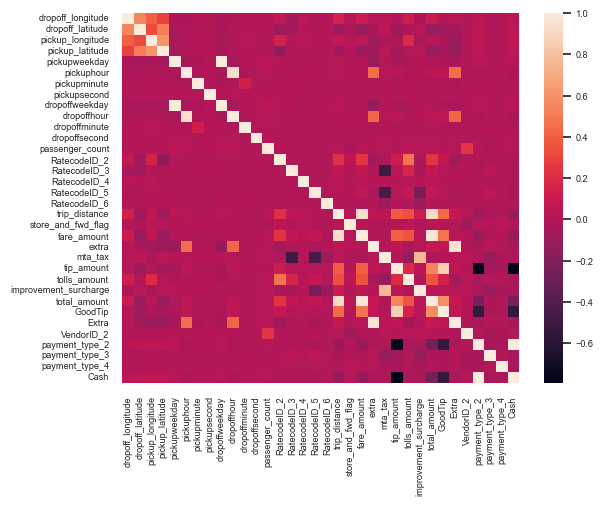

In [10]:
#spearman is used to catch non-linear correlation ()
sns.set(font_scale=0.6)
print(df.iloc[:, 9:].corr()['Cash'])
sns.heatmap(df.iloc[:, 9:].corr(method='spearman'))
plt.show()

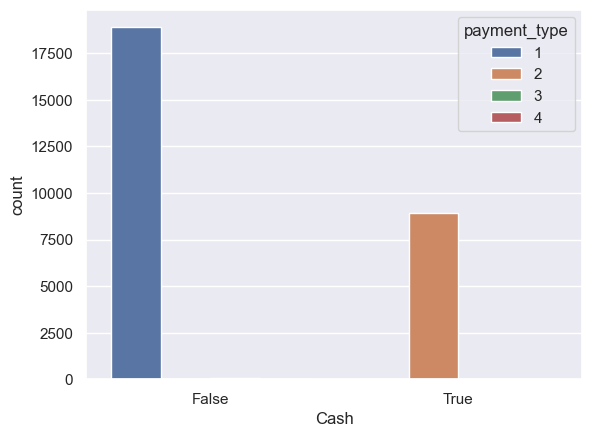

In [11]:
#here I remind the target value was 'Cash'
sns.set(font_scale=1)
sns.countplot(x=df.Cash, hue=df.payment_type)
plt.show()

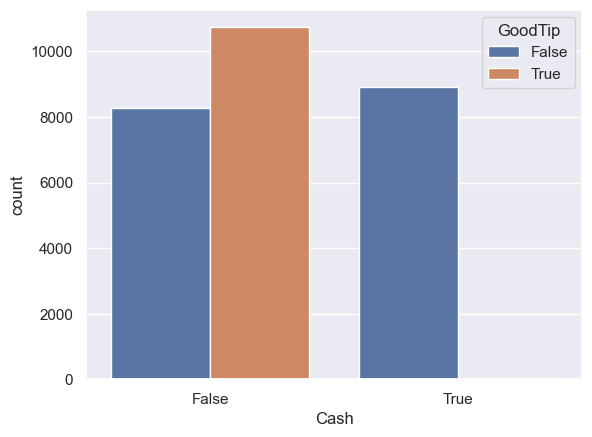

In [12]:
#there are 2 more features strongly correlated with Cash: tip_amount and Goodtip.
sns.countplot(x=df.Cash, hue=df.GoodTip)
plt.show()


[0.]


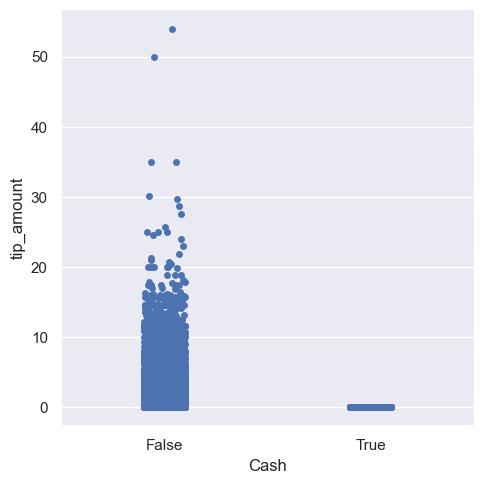

In [13]:
print(df[df.Cash==True].tip_amount.unique())
sns.catplot(x=df.Cash, y=df.tip_amount)
plt.show()

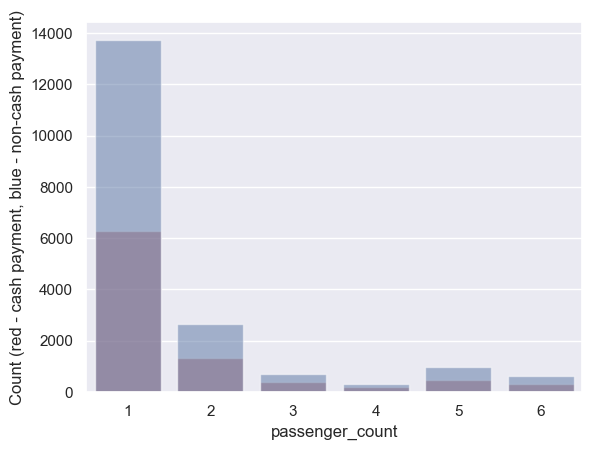

In [14]:
ax= plt.subplots()
ax = sns.countplot(data=df[df.Cash==True], x=df[df.Cash==True].passenger_count,  alpha = 0.5, color='r')
ax = sns.countplot(data=df[df.Cash==False], x=df[df.Cash==False].passenger_count,  alpha = 0.5, color='b')
ax.set(ylabel="Count (red - cash payment, blue - non-cash payment)")
plt.show()

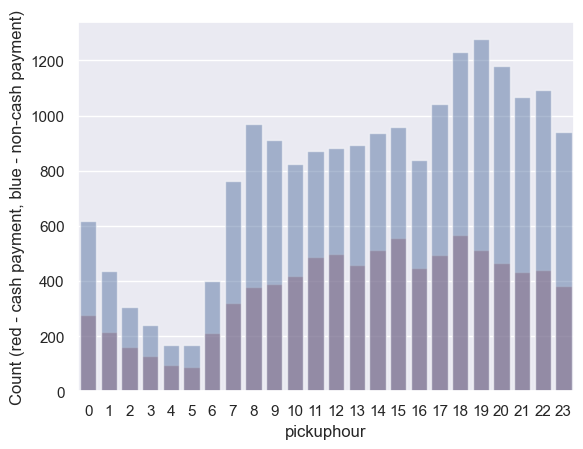

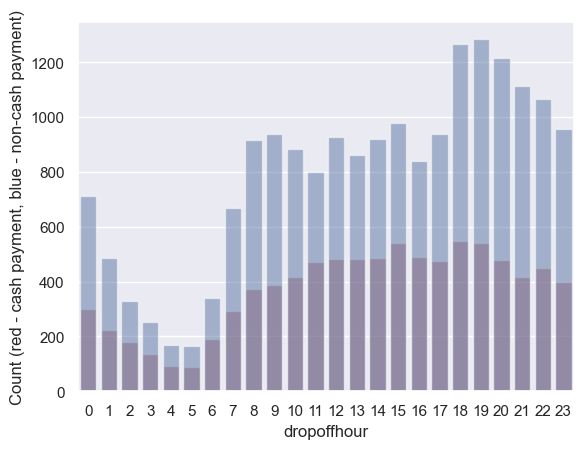

In [15]:
ax= plt.subplots()
ax = sns.countplot(data=df[df.Cash==True], x=df[df.Cash==True].pickuphour,  alpha = 0.5, color='r')
ax = sns.countplot(data=df[df.Cash==False], x=df[df.Cash==False].pickuphour,  alpha = 0.5, color='b')
ax.set(ylabel="Count (red - cash payment, blue - non-cash payment)")
plt.show()
ax= plt.subplots()
ax = sns.countplot(data=df[df.Cash==True], x=df[df.Cash==True].dropoffhour,  alpha = 0.5, color='r')
ax = sns.countplot(data=df[df.Cash==False], x=df[df.Cash==False].dropoffhour,  alpha = 0.5, color='b')
ax.set(ylabel="Count (red - cash payment, blue - non-cash payment)")
plt.show()

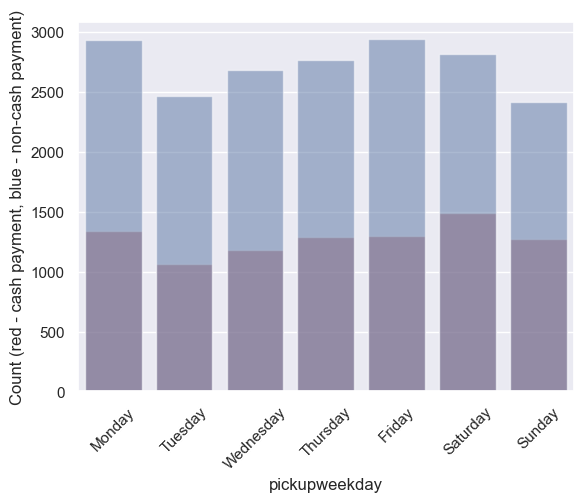

In [16]:
Daylabels = ['Monday', 'Tuesday','Wednesday', 'Thursday', 'Friday','Saturday', 'Sunday']
ax= plt.subplots()
ax = sns.countplot(data=df[df.Cash==True], x=df[df.Cash==True].pickupweekday,  alpha = 0.5, color='r')
ax = sns.countplot(data=df[df.Cash==False], x=df[df.Cash==False].pickupweekday,  alpha = 0.5, color='b')
ax.set_xticks(range(0,7))
ax.set_xticklabels(labels = Daylabels, rotation = 45)
ax.set(ylabel="Count (red - cash payment, blue - non-cash payment)")
plt.show()

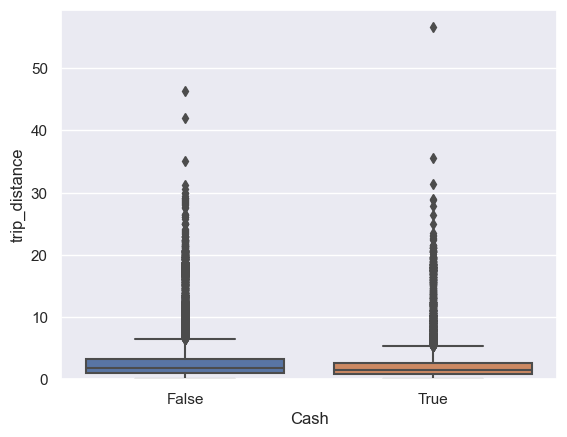

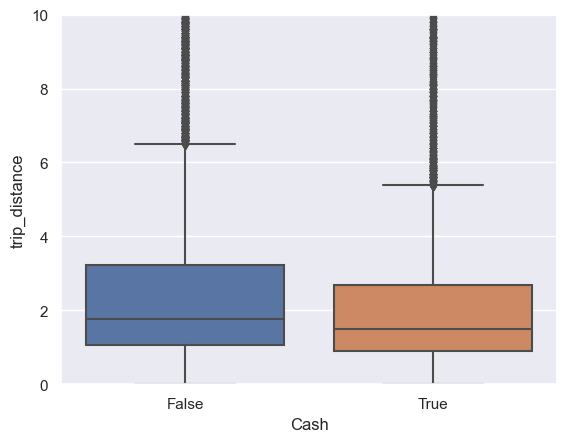

In [17]:
ax = sns.boxplot(data=df, x='Cash', y='trip_distance')
ax.set_ylim( bottom=0)
plt.show()
ax = sns.boxplot(data=df, x='Cash', y='trip_distance')
ax.set_ylim(top=10, bottom=0)
plt.show()

In [50]:
def model_assessment(predictors, target, outofbag=True, plot = True, max_depth=None, output1=True, output2 = False, nestimators=100, maxsamples=None):
    x_train, x_test, y_train, y_test = train_test_split(predictors, target, test_size=0.25, random_state=15)
    clf = RandomForestClassifier(oob_score=outofbag, max_depth=max_depth, n_estimators=nestimators, max_samples=maxsamples)
    clf.fit(x_train, y_train)

    if plot ==True:
        fidf = pd.DataFrame({'Feature': [], 'Feature importance score':[]})
        fidf.Feature=x_train.columns
        fidf['Feature importance score']=clf.feature_importances_
        fidf=fidf.sort_values('Feature importance score', ascending=False)
        ax=sns.barplot(y=fidf.Feature, x=fidf['Feature importance score'], orient='h')
        ax.set_yticks(range(0, len(fidf.Feature)))
        ax.set_yticklabels(labels=list(fidf.Feature))
        plt.show()

    yhatrain = clf.predict(x_train)
    predictiontrain = list(yhatrain)
    cmtrain = metrics.confusion_matrix(y_train, predictiontrain)
    yhattest = clf.predict(x_test)
    predictiontest = list(yhattest)
    cmtest = metrics.confusion_matrix(y_test, predictiontest)
   
    if output1==True:
        print ("Train Confusion Matrix : \n", cmtrain, '\n')
        print("Train Accuracy : ", metrics.accuracy_score(y_train, predictiontrain), '\n')
        print("Train f1-score : ", metrics.f1_score(y_train, predictiontrain), '\n')
        print("Train Recall : ", metrics.recall_score(y_train, predictiontrain), '\n')
        print("Train Precision : ", metrics.precision_score(y_train, predictiontrain), '\n')
     
        print ("Test Confusion Matrix : \n", cmtest)
        print("Test Accuracy : ", metrics.accuracy_score(y_test, predictiontest), '\n')
        print("Test f1-score : ", metrics.f1_score(y_test, predictiontest), '\n')
        print("Test Recall : ", metrics.recall_score(y_test, predictiontest), '\n')
        print("Test Precision : ", metrics.precision_score(y_test, predictiontest), '\n')

    if output2==True:
        return float(metrics.recall_score(y_test, predictiontest))


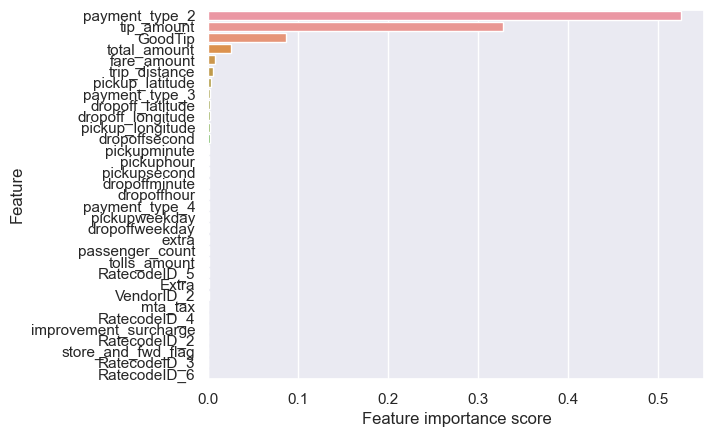

Train Confusion Matrix : 
 [[14233     0]
 [    0  6726]] 

Train Accuracy :  1.0 

Train f1-score :  1.0 

Train Recall :  1.0 

Train Precision :  1.0 

Test Confusion Matrix : 
 [[4782    0]
 [   0 2205]]
Test Accuracy :  1.0 

Test f1-score :  1.0 

Test Recall :  1.0 

Test Precision :  1.0 



In [21]:
predictors = df.iloc[:, 9:len(df.columns)-1]
target = df.Cash
model_assessment(predictors, target, outofbag=False)

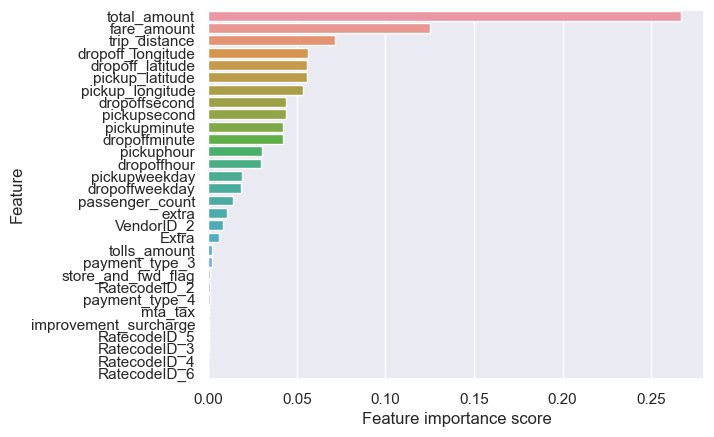

Train Confusion Matrix : 
 [[14233     0]
 [    0  6726]] 

Train Accuracy :  1.0 

Train f1-score :  1.0 

Train Recall :  1.0 

Train Precision :  1.0 

Test Confusion Matrix : 
 [[4622  160]
 [ 783 1422]]
Test Accuracy :  0.8650350651209389 

Test f1-score :  0.7509902297332981 

Test Recall :  0.6448979591836734 

Test Precision :  0.8988621997471555 



In [24]:
#and now let us drop our three most correlated values
df.drop(columns=['tip_amount', 'GoodTip', 'payment_type_2'], inplace=True, axis=1)
predictors = df.iloc[:, 9:len(df.columns)-1]
target = df.Cash
model_assessment(predictors, target, outofbag=False)

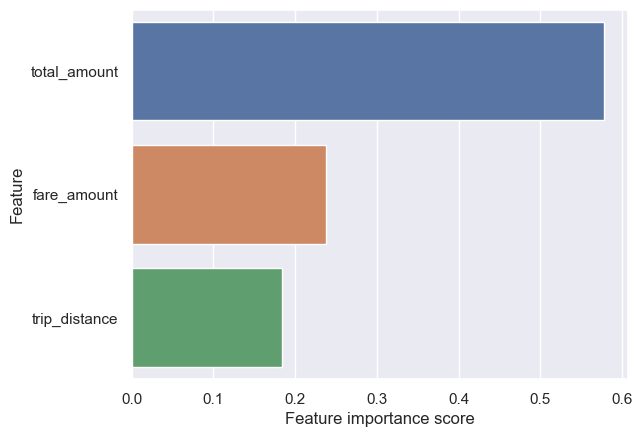

Train Confusion Matrix : 
 [[13837   396]
 [  177  6549]] 

Train Accuracy :  0.9726609093945322 

Train f1-score :  0.9580864603906079 

Train Recall :  0.9736842105263158 

Train Precision :  0.9429805615550756 

Test Confusion Matrix : 
 [[4408  374]
 [ 286 1919]]
Test Accuracy :  0.905538857878918 

Test f1-score :  0.853268119164073 

Test Recall :  0.8702947845804989 

Test Precision :  0.8368948975141736 



In [25]:
predictors = df[['total_amount', 'trip_distance', 'fare_amount']]
target = df.Cash
model_assessment(predictors, target)

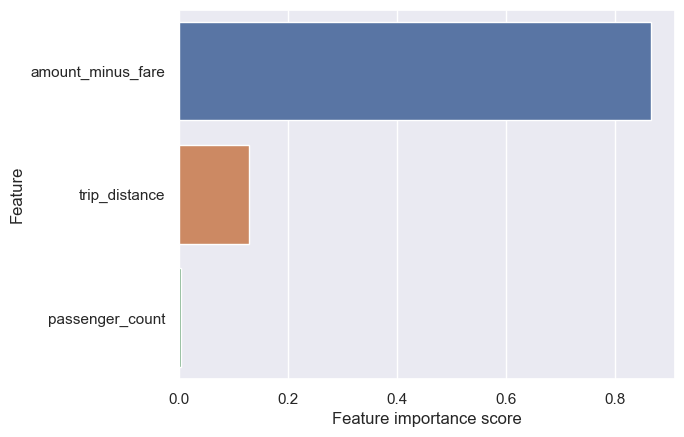

Train Confusion Matrix : 
 [[13749   484]
 [  358  6368]] 

Train Accuracy :  0.9598263275919653 

Train f1-score :  0.9379879216379438 

Train Recall :  0.9467737139458816 

Train Precision :  0.9293636894337419 

Test Confusion Matrix : 
 [[4436  346]
 [ 251 1954]]
Test Accuracy :  0.9145556032632031 

Test f1-score :  0.8674805771365148 

Test Recall :  0.8861678004535147 

Test Precision :  0.8495652173913043 



In [26]:
total_fare_delta = pd.DataFrame(np.array((df['total_amount'] - df['fare_amount']).reset_index(drop=True)).reshape(-1, 1)).rename(columns={0: 'amount_minus_fare'})
predictors=pd.concat([total_fare_delta, df.trip_distance, df.passenger_count], axis=1)
target = df.Cash
model_assessment(predictors, target)

In [29]:
df['amount_minus_fare above trip_distance'] = total_fare_delta.mul(df.trip_distance, axis=0)
predictors = pd.DataFrame(np.array((df['amount_minus_fare above trip_distance']).reset_index(drop=True)).reshape(-1, 1))
target = df.Cash
model_assessment(predictors, target, plot =False)

Train Confusion Matrix : 
 [[13029  1204]
 [  931  5795]] 

Train Accuracy :  0.8981344529796269 

Train f1-score :  0.8444444444444444 

Train Recall :  0.8615819209039548 

Train Precision :  0.827975425060723 

Test Confusion Matrix : 
 [[4050  732]
 [ 546 1659]]
Test Accuracy :  0.8170888793473594 

Test f1-score :  0.7219321148825065 

Test Recall :  0.7523809523809524 

Test Precision :  0.6938519447929736 



In [30]:
predictors = total_fare_delta
target = df.Cash
model_assessment(predictors, target, plot =False)

Train Confusion Matrix : 
 [[12810  1423]
 [   21  6705]] 

Train Accuracy :  0.9311035831862207 

Train f1-score :  0.9027871280463176 

Train Recall :  0.9968777876895629 

Train Precision :  0.8249261811023622 

Test Confusion Matrix : 
 [[4220  562]
 [   5 2200]]
Test Accuracy :  0.9188492915414341 

Test f1-score :  0.8858465874773506 

Test Recall :  0.9977324263038548 

Test Precision :  0.7965242577842143 



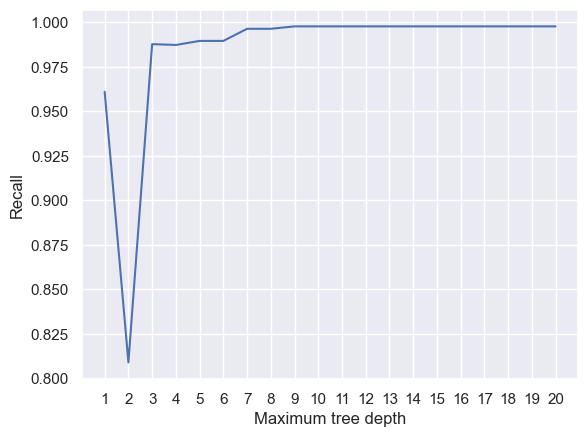

In [48]:
leest1 = []
leest2 = []
for i in range(1, 21, 1):
    leest1.append(model_assessment(predictors, target, plot = False, max_depth=i, output1=False, output2 = True))
    leest2.append(i)

ax=sns.lineplot(x=leest2, y=leest1)
ax.set_xticks(ticks = list(range(1, 21, 1)))
ax.set_xlabel(xlabel='Maximum tree depth')
ax.set_ylabel(ylabel='Recall')
plt.show()


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\User\AppDat

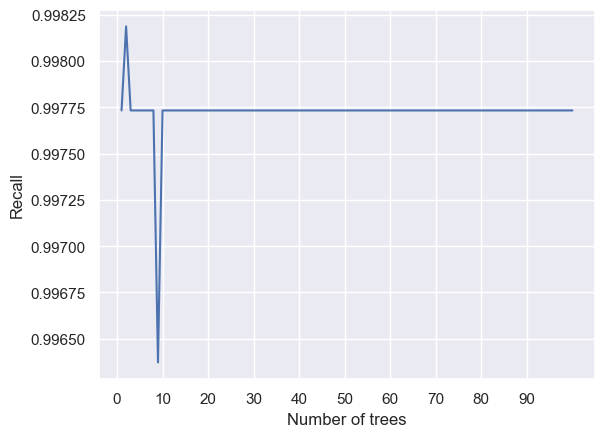

In [54]:
leest1 = []
leest2 = []
for i in range(1, 101, 1):
    leest1.append(model_assessment(predictors, target, plot = False, nestimators=i, output1=False, output2 = True))
    leest2.append(i)

ax=sns.lineplot(x=leest2, y=leest1)
ax.set_xticks(ticks = list(range(0, 100, 10)))
ax.set_xlabel(xlabel='Number of trees')
ax.set_ylabel(ylabel='Recall')
plt.show()

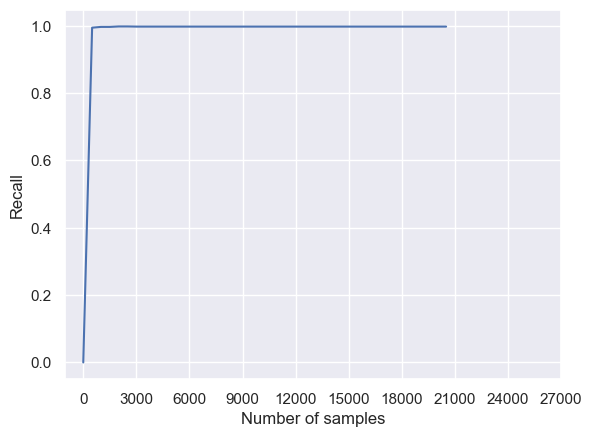

In [58]:
leest1 = []
leest2 = []
for i in range(1, 20959, 500):
    leest1.append(model_assessment(predictors, target, plot = False, maxsamples=i, output1=False, output2 = True))
    leest2.append(i)

ax=sns.lineplot(x=leest2, y=leest1)
ax.set_xticks(ticks = list(range(0, predictors.shape[0], 3000)))
ax.set_xlabel(xlabel='Number of samples')
ax.set_ylabel(ylabel='Recall')
plt.show()

In [ ]:
#and finally let us Gridsearch it
from sklearn.model_selection import GridSearchCV 
rf = RandomForestClassifier(criterion='log_loss', max_features = None)
parameters = {
    'criterion':['log_loss', 'entropy', 'gini'],
    'max_features': ['sqrt', 'log2', None],
    'max_depth':list(range(7,21,1))
     }
results = GridSearchCV(rf, parameters, cv=10, verbose=2, return_train_score=True, scoring='recall')
results.fit(x_train, y_train)
results.best_params_